<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tf2/time-series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series / Sequences

Example, some code and a lot of inspiration taken from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/


In [1]:
!pip install -q tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 346.4MB 56kB/s 
     |████████████████████████████████| 430kB 43.9MB/s 
     |████████████████████████████████| 3.1MB 35.8MB/s 
     |████████████████████████████████| 61kB 24.1MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190502


## Univariate Sequences

just one variable per time step

### Challenge

We have a known series of events, possibly in time and you want to know what is the next event. Like this

[10, 20, 30, 40, 50, 60, 70, 80, 90]

In [0]:
# univariate data preparation
import numpy as np

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [4]:
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# summarize the data
list(zip(X, y))

[(array([10, 20, 30]), 40),
 (array([20, 30, 40]), 50),
 (array([30, 40, 50]), 60),
 (array([40, 50, 60]), 70),
 (array([50, 60, 70]), 80),
 (array([60, 70, 80]), 90)]

In [5]:
X

array([[10, 20, 30],
       [20, 30, 40],
       [30, 40, 50],
       [40, 50, 60],
       [50, 60, 70],
       [60, 70, 80]])

### Converting shapes

* one of the most frequent, yet most tedious steps
* match between what you have and what an interface needs
* expected input of RNN: 3D tensor featureswith shape (samples, timesteps, input_dim)
* we have: (samples, timesteps)
* reshape on np arrays can do all that

In [6]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X

array([[[10],
        [20],
        [30]],

       [[20],
        [30],
        [40]],

       [[30],
        [40],
        [50]],

       [[40],
        [50],
        [60]],

       [[50],
        [60],
        [70]],

       [[60],
        [70],
        [80]]])

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

model = Sequential()
model.add(SimpleRNN(units=50, activation='relu', input_shape=(n_steps, n_features), name="RNN_Input"))
model.add(Dense(units=1, name="Linear_Output"))
model.compile(optimizer='adam', loss='mse')

In [15]:
EPOCHS = 500

%time history = model.fit(X, y, epochs=EPOCHS, verbose=0)

CPU times: user 2.22 s, sys: 189 ms, total: 2.41 s
Wall time: 1.93 s


In [16]:
loss = model.evaluate(X, y)
loss

6/6 [==============================] - 0s 8ms/sample - loss: 0.0013


0.0013315972173586488

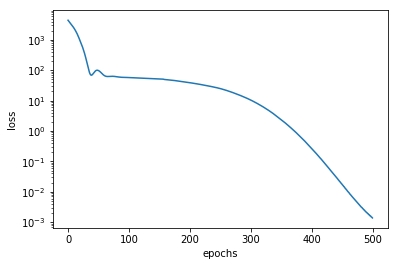

In [17]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])

In [18]:
# this does not look too bad
X_sample = np.array([[10, 20, 30], [70, 80, 90]])
X_sample = X_sample.reshape((X_sample.shape[0], X_sample.shape[1], n_features))
X_sample

array([[[10],
        [20],
        [30]],

       [[70],
        [80],
        [90]]])

In [19]:
y_pred = model.predict(X_sample)
y_pred

array([[ 39.92145],
       [100.26933]], dtype=float32)

In [0]:
def predict(model, samples, n_features=1):
  input = np.array(samples)
  input = input.reshape((input.shape[0], input.shape[1], n_features))
  y_pred = model.predict(input)
  return y_pred

In [21]:
# do not look too close, though
predict(model, [[100, 110, 120], [200, 210, 220], [200, 300, 400]])

array([[131.38614],
       [235.33505],
       [478.7933 ]], dtype=float32)

### Input and output of an RNN layer

In [22]:
# https://keras.io/layers/recurrent/
# input: (samples, timesteps, input_dim)
# output: (samples, units)

# let's have a look at the actual output for an example
rnn_layer = model.get_layer("RNN_Input")
model_stub = Model(inputs = model.input, outputs = rnn_layer.output)
hidden = predict(model_stub, [[10, 20, 30]])
hidden

array([[ 0.        ,  8.914725  ,  0.        ,  6.6223903 ,  0.        ,
         0.        , 13.717172  ,  0.        ,  0.        ,  3.6797295 ,
         7.718167  ,  0.        , 12.330741  , 14.235772  ,  0.        ,
         0.        , 10.540234  ,  0.        ,  4.2248764 ,  0.        ,
         0.        , 18.461843  , 12.176587  ,  0.        ,  0.        ,
         8.216896  ,  0.        ,  0.        ,  0.        , 18.876797  ,
         0.        , 13.914774  , 11.406943  ,  0.        ,  0.        ,
         0.        , 15.846443  ,  7.6130967 ,  9.40387   ,  0.        ,
        19.461048  ,  0.02111149,  9.895727  , 10.7871475 ,  3.546275  ,
         0.        ,  0.        , 12.707142  ,  0.        ,  0.        ]],
      dtype=float32)

#### What do we see?
* each unit (50) has a single output
* as a sidenote you nicely see the RELU nature of the output
* so the timesteps are lost
* we are only looking at the final output
* still with each timestep, the layer does produce a unique output we can use

### We need to look into RNNs a bit more deeply now

#### RNNs - Networks with Loops
<img src='https://djcordhose.github.io/ai/img/nlp/colah/RNN-rolled.png' height=200>

http://colah.github.io/posts/2015-08-Understanding-LSTMs/
#### Unrolling the loop
<img src='https://djcordhose.github.io/ai/img/nlp/colah/RNN-unrolled.png'>

http://colah.github.io/posts/2015-08-Understanding-LSTMs/
#### Simple RNN internals

<img src='https://djcordhose.github.io/ai/img/nlp/fchollet_rnn.png'>

##  $output_t = \tanh(W input_t + U output_{t-1} + b)$

From Deep Learning with Python, Chapter 6, François Chollet, Manning: https://livebook.manning.com/#!/book/deep-learning-with-python/chapter-6/129

#### Activation functions

<img src='https://djcordhose.github.io/ai/img/sigmoid-activation.png' height=200>

Sigmoid compressing between 0 and 1

<img src='https://djcordhose.github.io/ai/img/tanh-activation.png' height=200>

Hyperbolic tangent, like sigmoind, but compressing between -1 and 1, thus allowing for negative values as well